In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

### 요인분석
#### 우리는 기존에 가중치를 산정하여 순위를 산출하였다->기준 : 주관적인 기준 (원래는 AHP등 전문가의 조언을 인용하면 더 좋다.)
#### 이것과 별개로 통계학적 관점에서 요인분석의 적재량을 통해 변수들의 가중치를 설정해보고자 한다
#### 주의해야할 점 : 단순히 수치적인 관점에서 분산등을 통해 데이터가 어떻게 설명되는지 바라보는 관점이며, 이 관점이 현실세계에서 유의미하게 적용된다는 보장이 없다. 
#### 따라서 두 가지 모델 ( A : 우리가 만든 모델 B: 요인분석을 통해 가중치를 준 모델) 은 모델링의 방향성이 다르기 때문에, 두 가지 결과를 모두 활용하여 최종 제언을 하는 것은 프로젝트의 완성도를 높여줄 것이라 생각


### 목적 : 요인분석을 통한 수치적 관점에서의 가중치 산출 및 약국 순위 도출

In [6]:
df=pd.read_csv('약국별속성최종본.csv',encoding='EUC-KR')
df.head()

,이름,도로명주소,Latitude,Longitude,구이름,동이름,응급실개수,버스개수,지하철개수,편의점개수,심야약국개수,평균유동인구,평균생활인구수,경증환자_약품비,기타환자_약품비,전체환자_약품비,경증환자수,기타환자수,전체환자수,경증_약품비_비율,경증_환자수_비율,반경내_세대수_합,반경내_인구수_합,응급실_평균거리,버스_평균거리,지하철_평균거리,편의점_평균거리,심야약국_평균거리,동_생활인구_평균,동_유동인구_합,동_거주인구_합,반경내_생활인구_추정,bus_ratio,sub_ratio,store_ratio,emer_ratio,nd_ratio
0,100세건강약국,서울특별시 강남구 헌릉로571길 7,37.46605,127.10135,강남구,세곡동,0,16,0,4,0,9.40458,50675.20131,88391.40000,259419.40000,347810.80000,6047.40000,6836.60000,12884.20000,0.25414,0.46937,173.46000,329.55000,0.00000,196.86804,0.00000,174.39275,0.00000,50675.20131,38.64902,4234.34000,16274.89798,0.08127,0.00000,43.59819,0.00000,0.00000
1,강남리더스약국,서울특별시 강남구 헌릉로 569,37.46578,127.10119,강남구,세곡동,0,15,0,4,0,9.40458,50675.20131,88391.40000,259419.40000,347810.80000,6047.40000,6836.60000,12884.20000,0.25414,0.46937,173.46000,329.55000,0.00000,181.20494,0.00000,186.88110,0.00000,50675.20131,38.64902,4234.34000,16274.89798,0.08278,0.00000,46.72027,0.00000,0.00000
2,더조은약국,서울특별시 강남구 자곡로3길 21,37.47128,127.08869,강남구,세곡동,0,2,0,4,0,0.00000,50675.20131,88391.40000,259419.40000,347810.80000,6047.40000,6836.60000,12884.20000,0.25414,0.46937,4.64000,10.68000,0.00000,307.20926,0.00000,149.40110,0.00000,50675.20131,38.64902,4234.34000,127.81476,0.00651,0.00000,37.35028,0.00000,0.00000
3,동의보감한약국,서울특별시 강남구 헌릉로571길 56-1,37.46766,127.09875,강남구,세곡동,0,12,0,3,0,9.40458,50675.20131,88391.40000,259419.40000,347810.80000,6047.40000,6836.60000,12884.20000,0.25414,0.46937,280.05000,510.27000,0.00000,252.22980,0.00000,271.36474,0.00000,50675.20131,38.64902,4234.34000,18437.69605,0.04758,0.00000,90.45491,0.00000,0.00000
4,메디칼정성약국,서울특별시 강남구 밤고개로21길 8,37.47360,127.10767,강남구,세곡동,0,10,0,10,0,0.09155,50675.20131,88391.40000,259419.40000,347810.80000,6047.40000,6836.60000,12884.20000,0.25414,0.46937,250.80000,588.15000,0.00000,238.24647,0.00000,285.79279,0.00000,50675.20131,38.64902,4234.34000,7158.82412,0.04197,0.00000,28.57928,0.00000,0.00000


In [7]:
df_score = df[['경증환자수','경증환자_약품비','경증_환자수_비율','경증_약품비_비율','평균유동인구','반경내_인구수_합','반경내_생활인구_추정',\
          '버스개수','지하철개수','bus_ratio','sub_ratio',\
          'store_ratio','nd_ratio','emer_ratio','응급실개수','심야약국개수','편의점개수']]



In [8]:
df_score

,경증환자수,경증환자_약품비,경증_환자수_비율,경증_약품비_비율,평균유동인구,반경내_인구수_합,반경내_생활인구_추정,버스개수,지하철개수,bus_ratio,sub_ratio,store_ratio,nd_ratio,emer_ratio,응급실개수,심야약국개수,편의점개수
0,6047.40000,88391.40000,0.46937,0.25414,9.40458,329.55000,16274.89798,16,0,0.08127,0.00000,43.59819,0.00000,0.00000,0,0,4
1,6047.40000,88391.40000,0.46937,0.25414,9.40458,329.55000,16274.89798,15,0,0.08278,0.00000,46.72027,0.00000,0.00000,0,0,4
2,6047.40000,88391.40000,0.46937,0.25414,0.00000,10.68000,127.81476,2,0,0.00651,0.00000,37.35028,0.00000,0.00000,0,0,4
3,6047.40000,88391.40000,0.46937,0.25414,9.40458,510.27000,18437.69605,12,0,0.04758,0.00000,90.45491,0.00000,0.00000,0,0,3
4,6047.40000,88391.40000,0.46937,0.25414,0.09155,588.15000,7158.82412,10,0,0.04197,0.00000,28.57928,0.00000,0.00000,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5076,2366.20000,32371.60000,0.60458,0.39408,137.07320,17053.16000,13392.62486,29,1,0.11377,0.00330,63.34940,0.00000,0.00000,0,0,3
5077,3620.20000,45087.60000,0.69408,0.73263,266.78062,11749.62000,18048.72744,15,0,0.06523,0.00000,12.72518,346.25763,0.00000,0,1,20
5078,3620.20000,45087.60000,0.69408,0.73263,473.64556,12881.16000,25061.11164,12,0,0.04141,0.00000,11.65618,372.31701,0.00000,0,1,22
5079,2543.20000,40852.60000,0.40732,0.18187,349.73692,7973.78000,33686.78901,9,0,0.03019,0.00000,64.50742,0.00000,0.00000,0,0,4


In [9]:

#FA를 위한 standard scaling
scaler = MinMaxScaler()

df_score_scaled=pd.DataFrame(scaler.fit_transform(df_score),columns= df_score.columns )
df_score_scaled

,경증환자수,경증환자_약품비,경증_환자수_비율,경증_약품비_비율,평균유동인구,반경내_인구수_합,반경내_생활인구_추정,버스개수,지하철개수,bus_ratio,sub_ratio,store_ratio,nd_ratio,emer_ratio,응급실개수,심야약국개수,편의점개수
0,1.00000,1.00000,0.35051,0.17781,0.00296,0.00868,0.40552,0.39024,0.00000,0.42830,0.00000,0.11325,0.00000,0.00000,0.00000,0.00000,0.09756
1,1.00000,1.00000,0.35051,0.17781,0.00296,0.00868,0.40552,0.36585,0.00000,0.43623,0.00000,0.12136,0.00000,0.00000,0.00000,0.00000,0.09756
2,1.00000,1.00000,0.35051,0.17781,0.00000,0.00028,0.00318,0.04878,0.00000,0.03431,0.00000,0.09702,0.00000,0.00000,0.00000,0.00000,0.09756
3,1.00000,1.00000,0.35051,0.17781,0.00296,0.01344,0.45941,0.29268,0.00000,0.25072,0.00000,0.23496,0.00000,0.00000,0.00000,0.00000,0.07317
4,1.00000,1.00000,0.35051,0.17781,0.00003,0.01549,0.17838,0.24390,0.00000,0.22119,0.00000,0.07424,0.00000,0.00000,0.00000,0.00000,0.24390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5076,0.19911,0.16684,0.74131,0.41827,0.04312,0.44911,0.33370,0.70732,0.20000,0.59953,0.02572,0.16455,0.00000,0.00000,0.00000,0.00000,0.07317
5077,0.47193,0.35596,1.00000,1.00000,0.08392,0.30944,0.44972,0.36585,0.00000,0.34375,0.00000,0.03305,0.86692,0.00000,0.00000,0.14286,0.48780
5078,0.47193,0.35596,1.00000,1.00000,0.14900,0.33924,0.62444,0.29268,0.00000,0.21823,0.00000,0.03028,0.93217,0.00000,0.00000,0.14286,0.53659
5079,0.23762,0.29297,0.17117,0.05363,0.11002,0.21000,0.83937,0.21951,0.00000,0.15910,0.00000,0.16756,0.00000,0.00000,0.00000,0.00000,0.09756


### KMO 지수 산출

In [10]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all,kmo_model=calculate_kmo(df_score_scaled)

kmo_model

0.586010191477236

* 일반적으로 0.5~0.6이상이면 KMO 분석이 가능
* 전체환자수와 전체 약품비를 포함하면 KMO가 높아지지만 (높은상관관계를지닌컬럼이기때문) , 프로젝트 주제 관점에서의 변수를 선택함에 있어서 전체환자수보다는 경증환자 데이터만 유의할 것이라고 생각했기 때문에, kmo 지수의 손해를 감수하고 의미적으로 관련있는 변수를 선택함

## 요인분석실시

In [11]:
from factor_analyzer.factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=17,rotation=None)
fa.fit(df_score_scaled)

ev,v=fa.get_eigenvalues()
ev

array([3.23995479, 3.07089106, 1.85824403, 1.64725394, 1.2736545 ,
       1.20539223, 1.05298946, 0.94542623, 0.76906721, 0.55890133,
       0.42690935, 0.3397585 , 0.32157439, 0.16680976, 0.05835843,
       0.05008134, 0.01473344])

* 일반적으로 기여율이 1이상인 부분까지만 요인을 축소시킴

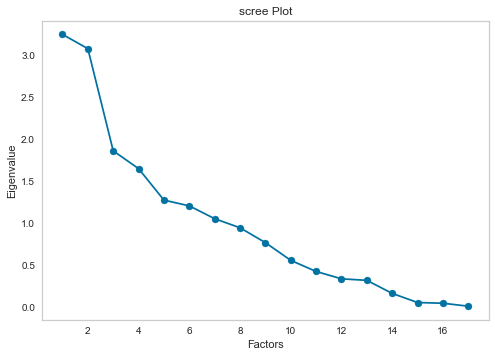

In [12]:
plt.scatter(range(1,df_score_scaled.shape[1]+1),ev)
plt.plot(range(1,df_score_scaled.shape[1]+1),ev)
plt.title('scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

* scree plot과 eignvalues를 참고하여 6개의 요인으로 축소시키고자함

In [13]:
from factor_analyzer import FactorAnalyzer
fa=FactorAnalyzer(n_factors=6,rotation='varimax')
fa.fit(df_score_scaled)
fa.get_factor_variance()

(array([2.09598512, 1.96171958, 1.87189527, 1.79133795, 1.71602054,
        1.40499838]),
 array([0.12329324, 0.11539527, 0.11011149, 0.10537282, 0.10094238,
        0.08264696]),
 array([0.12329324, 0.23868851, 0.3488    , 0.45417282, 0.5551152 ,
        0.63776217]))

* 6개요인을 이용하면 64% 정도의 분산이 설명가능하다. 일반적으로 60%이상이면 준수

### 가중치 부여 아이디어
* 사전에 KMO 계수를 통하여 변수들을 전체적으로 통합해서 보아도, 요인분석이 유의할 것이라는 점을 미리 확인함
* 자체적으로는 의미있다고 생각한 변수들이 통계적으로는 상관관계가 없을 수 있음 ex) 응급실과 편의점은 경쟁요인으로 묶일 수 있으나, 수치상 으로 상관관계는 전혀 never 1도 없음
* 따라서 각 요인별로 어떤 수치가 묶여서 높게 나오는 지는 고려하지 않고  특정 변수가 각 요인들에 의해 얼마나 설명이 되는지를 활용하여 가중치를 나누려고함
* 즉, 각 요인들에 해당 변수가 얼마나 영향력이 있는지, 계수만을 추려내어 평균을 내면 평균적인 영향력이 나올 것이다
* 값이 가장 높은 변수는 요인들에 의해 평균적으로 가장 잘 설명 된다는 것을 의미 -> 평균적으로 가장 많은 영향력이 있다고 해석함

In [14]:
fa=FactorAnalyzer(n_factors=6,rotation='varimax')
fa.fit(df_score_scaled)
efa_result = pd.DataFrame(fa.loadings_,columns=np.array([f"fa{num+1}" for num in range(6)]),index=df_score_scaled.columns)
efa_result['mean']=( abs(efa_result['fa1']) + abs(efa_result['fa2'])+ abs(efa_result['fa3'])\
                    + abs(efa_result['fa4']) + abs(efa_result['fa5']) + abs(efa_result['fa6'])\
                    ) / 6

efa_result= efa_result.sort_values('mean')
efa_result

,fa1,fa2,fa3,fa4,fa5,fa6,mean
반경내_생활인구_추정,0.21556,-0.06874,0.07351,-0.07254,-0.06013,-0.05682,0.09122
nd_ratio,-0.01987,-0.02750,-0.02479,0.43787,-0.04273,-0.01318,0.09432
store_ratio,-0.06239,0.03401,-0.07763,-0.39471,-0.06779,-0.07802,0.11909
emer_ratio,0.00552,-0.01761,0.00470,0.05120,0.85902,0.00239,0.15674
반경내_인구수_합,0.35092,0.07839,0.02351,-0.12978,-0.12324,-0.25653,0.16039
심야약국개수,-0.06606,-0.00545,0.04708,0.69580,-0.05208,0.09748,0.16066
sub_ratio,-0.04940,0.03309,0.06694,0.16446,-0.01320,0.66124,0.16472
응급실개수,-0.03661,-0.04547,0.03039,0.03634,0.95394,-0.01288,0.18594
평균유동인구,-0.14427,0.08213,0.10196,0.54127,0.08329,0.23280,0.19762
경증_환자수_비율,0.98907,-0.13614,0.00593,0.04561,0.06051,-0.01582,0.20885


* 나온 평균 적재율을 정렬한 결과는 수치적으로 잘 설명되는, 영향력이 있는 순으로 정렬된 것
* bus_ratio가 1위라는건, 평균적으로 bus_ratio가 요인들에 의해 잘 설명된다는 것이고, 영향력이 가장 큰 변수라고 해석이 가능 -> 이해가 안될수있지만 수치적으로는 그렇다는것
* 기존의 모델에서는 의미있을거라 생각했던 변수들을 묶어 가중치를 일괄적으로 부여, 계산을 하였음
* 요인분석에서는 변수들이 가진 평균 영향력에 따라 개별적인 가중치를 부여하여 점수를 산출 -> 얼마나 차이가 날 것인지..

# 점 수 산 출

In [15]:
efa=[]
efa=efa_result.index

In [16]:
df_fa = pd.DataFrame()

In [17]:
for i in range(df_score_scaled.shape[1]):
    df_fa[efa[i]]=df_score_scaled[efa[i]]*(0.1*(i+1))

In [18]:
df_fa['잠재구매']= df_fa['경증환자수']+\
df_fa['경증환자_약품비']+ \
df_fa['경증_약품비_비율']+ \
df_fa['경증_환자수_비율']+ \
df_fa['반경내_생활인구_추정']+\
df_fa['평균유동인구']+\
df_fa['반경내_인구수_합']
df_fa['잠재구매지수']=df_fa['잠재구매']/2.59


In [19]:
df_fa['교통접근']= df_fa['버스개수'] +\
df_fa['지하철개수']+\
df_fa['bus_ratio']+\
df_fa['sub_ratio']
df_fa['교통접근지수']=df_fa['교통접근']/2.59

In [20]:
df_fa['잠재경쟁']=df_fa['store_ratio']+\
df_fa['nd_ratio']+df_fa['emer_ratio']+\
df_fa['응급실개수']+\
df_fa['심야약국개수']+\
df_fa['편의점개수']
df_fa['잠재경쟁지수']=df_fa['잠재경쟁']/2.59

In [21]:
df_fa_score = df_fa.copy()

df_fa_score = df_fa[['잠재구매지수','교통접근지수','잠재경쟁지수']]

In [22]:
df_fa_score['총점']=(df_fa_score['잠재경쟁지수']+df_fa_score['잠재구매지수']+df_fa_score['교통접근지수'])
df_fa_score['순위'] = df_fa_score['총점'].rank(ascending=False)
df_fa_score

,잠재구매지수,교통접근지수,잠재경쟁지수,총점,순위
0,1.36950,0.50713,0.05455,1.93118,2430.00000
1,1.36950,0.49822,0.05549,1.92320,2488.00000
2,1.35131,0.05077,0.05267,1.45475,4514.00000
3,1.37249,0.33407,0.05829,1.76486,3352.00000
4,1.36102,0.28644,0.11219,1.75965,3376.00000
...,...,...,...,...,...
5076,0.82989,0.90277,0.05014,1.78280,3258.00000
5077,1.48968,0.43751,0.31104,2.23824,1037.00000
5078,1.52479,0.31275,0.33648,2.17401,1300.00000
5079,0.50651,0.23156,0.06084,0.79891,5068.00000


In [23]:
df_fin = pd.concat([df[df.columns[0:6]],df_fa_score],axis=1)
df_fin.sort_values('순위')

,이름,도로명주소,Latitude,Longitude,구이름,동이름,잠재구매지수,교통접근지수,잠재경쟁지수,총점,순위
2987,용약국,서울특별시 마포구 신촌로 102-1,37.55460,126.93738,마포구,대흥동,1.56905,1.02047,0.75244,3.34196,1.00000
3286,더블유스토어연세약국,서울특별시 마포구 신촌로 92,37.55517,126.93567,마포구,서교동,1.57674,1.01784,0.74545,3.34003,2.00000
3299,올리브약국,서울특별시 마포구 신촌로 88,37.55537,126.93537,마포구,서교동,1.57873,1.00623,0.74985,3.33481,3.00000
2985,신촌성은약국,서울특별시 마포구 서강로 138,37.55413,126.93597,마포구,대흥동,1.57219,1.00413,0.67532,3.25164,4.00000
1749,강남씨티약국,서울특별시 강남구 강남대로 416,37.49982,127.02718,강남구,역삼1동,1.66502,1.14728,0.43351,3.24581,5.00000
...,...,...,...,...,...,...,...,...,...,...,...
2870,국화약국,서울특별시 종로구 평창11길 3,37.60596,126.96642,종로구,평창동,0.30623,0.30679,0.04950,0.66252,5077.00000
5028,우리약국,서울특별시 종로구 옥인길 32-5 (옥인동),37.58110,126.96679,종로구,청운효자동,0.33193,0.26338,0.06629,0.66160,5078.00000
5036,세이지약국,서울특별시 서대문구 이화여대길 52,37.56667,126.95031,서대문구,충현동,0.43650,0.14662,0.07021,0.65332,5079.00000
3804,효성약국,서울특별시 종로구 창신길 95 (창신동),37.57586,127.01031,종로구,창신2동,0.38587,0.02317,0.15851,0.56755,5080.00000


In [24]:
df_fin.to_csv('FA_최종산출데이터.csv',encoding='euc-kr',index=False)

* 세부적으로 조금씩 순위 변동이 있긴 하나, 눈에 크게 띄는 차이는 없는 듯 함
* 데이터상으로도 교통관련 지수가 영향력이 가장 큰 편에 속하고 자체 가중치에서도 교통지수를 가장 높은 가중치를 주었음
* 분석 방향성이 어느정도 일치한다는 점을 보여줌
* 요인분석을 기반으로 변수들을 나눠서 우리가 자체적으로 가중치를 부여햇어도 비슷하게 부여했을 것이라는 의미
